In [8]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import warnings
warnings.filterwarnings('ignore')

## GPU 메모리 활용방법
1. gradient accumulation
2. gradient checkpointing


GPU 사용시 가장 자주 만나는 에러는 **Out of memory** 에러다. 한정된 GPU 메모리에 데이터가 가득 차 추가하지 못해 발성하는 에러다.
GPU 에는 딥러닝 모델 자체가 올라간다. 모델은 수많은 행렬 곱셈을 위한 파라미터 집합이다.

### 딥러닝 모델의 데이터 타입

- 컴퓨터에서는 소수연산을 위해 32 비트 부동 소수점을 사용한다. 만약 세밀한 계산이 필요하다면 64비트를 사용한다.부동소수점을 나타내는 비트의 수가 커질수록 표현할 수 있는 수의 범위나 세밀한 정도가 달라진다.
- 모델은 input 데이터를 최종 output까지 많은 행렬 곱 파라미터로 구성된다. 과거에는 32비트를 사용해 저장했지만, 파라미터가 많은 모델을 사용하면서 메모리 부족이나 계산이 오래 걸리는 문제가 발생했다.  이 문제 해결을 위해 더 작은 타입을 사용하는 방향으로 발전했다. 최근에는 <span style='color: blue'>**16비트 수로 표현하는 fp16 또는 bf16**</span>을 주로 사용한다

#### fp32,fp16,bf16
- fp32는 32비트를 사용해 부호, 지수 8비트, 가수 23비트를 사용하는데 넓은 범위를 촘촘하게 표현할 수 있다.
- fp16은 지수 부호, 지수 5비트, 가수 10비트를 사용한다.
- bf16은  Google의 TPU에서 사용되는 형식으로 부호,지수 8비트, 가수 7비트를 사용한다. 그래서 fp32에 비해 적은 메모리를 사용하면서도 fp16보다 높은 범위의 값을 처리할 수 있습니다.

In [9]:
import numpy as np
import torch

# Create a large array of random numbers
data = np.random.rand(1000).astype(np.float32)  # FP32 data

# Convert the array to PyTorch tensors in different formats
tensor_fp32 = torch.tensor(data, dtype=torch.float32)
tensor_fp16 = torch.tensor(data, dtype=torch.float16)
tensor_bf16 = torch.tensor(data, dtype=torch.bfloat16)

# Define a simple operation to compare precision (e.g., summation)
def compare_precision(tensor):
    result = tensor.sum()
    return result

# Perform the operation for each precision
result_fp32 = compare_precision(tensor_fp32)
result_fp16 = compare_precision(tensor_fp16)
result_bf16 = compare_precision(tensor_bf16)

print(f"FP32 result: {result_fp32.item()}")
print(f"FP16 result: {result_fp16.item()}")
print(f"BF16 result: {result_bf16.item()}")

# Calculate the differences
diff_fp16 = abs(result_fp32.item() - result_fp16.item())
diff_bf16 = abs(result_fp32.item() - result_bf16.item())

print(f"Difference between FP32 and FP16: {diff_fp16}")
print(f"Difference between FP32 and BF16: {diff_bf16}")


FP32 result: 502.0142822265625
FP16 result: 502.0
BF16 result: 502.0
Difference between FP32 and FP16: 0.0142822265625
Difference between FP32 and BF16: 0.0142822265625


#### 양자화 quantization
- 모델 파라미터의 데이터 타입이 더 많은 비트를 사용할 수록 모델 용량이 커지기 때문에 더 작은 비트로 모델을 표현 하는 양자화 기술이 개발되었다.
- 예를들어 fp32 모델을을 fp16형식으로 저장하면 모델 용량은 절반이 되지만, 정보가 소실될 수 있는데 이런 양자화는 모델의 성능이 저하된다. **<span style= 'color:blue'>더 적은 비트를 사용하면서 원본 데이터의 정보를 최대한 소실 없이 유지하는 것이 핵심**</span>이다.

#### 선형 양자화
- 데이터 형식의 최대값과 최소값을 대응 시키는 방식
- FP32 데이터를 INT8 데이터로 변환 하게 되면 **정밀도 손실**이 일어 날 수 있다.

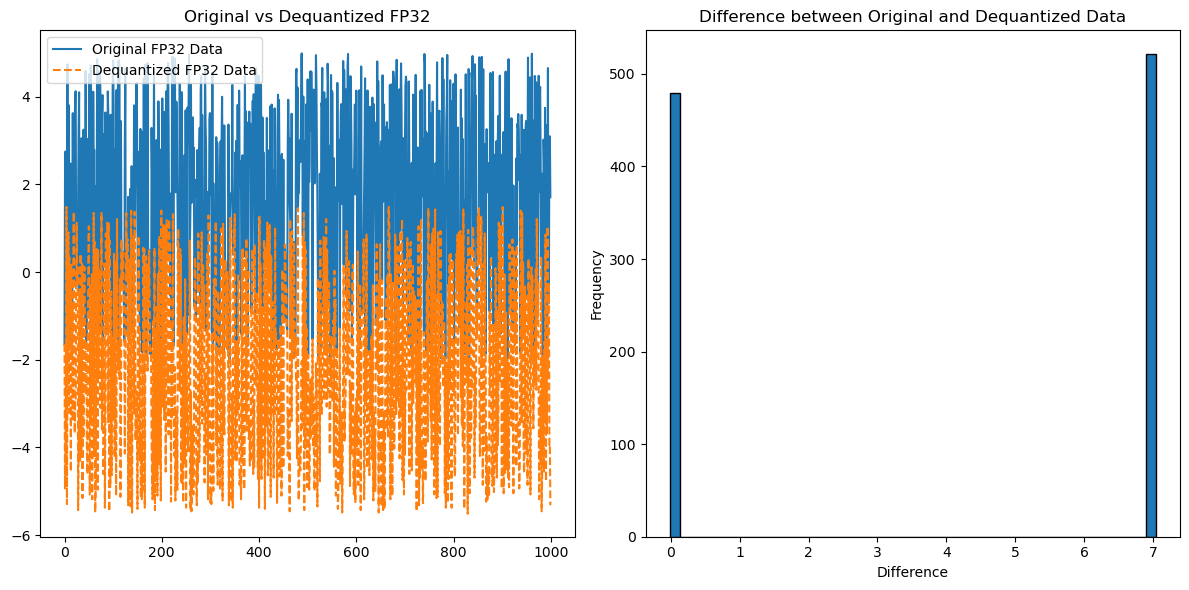

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# 1. 원본 FP32 데이터를 생성 (예: -2.0에서 5.0 사이의 랜덤 값)
fp32_data = np.random.uniform(-2.0, 5.0, 1000)

# 2. FP32 데이터를 INT8로 선형 양자화
fp32_min, fp32_max = -2.0, 5.0  # FP32 범위
int8_min, int8_max = -128, 127  # INT8 범위

# 선형 양자화 함수
def quantize_fp32_to_int8(fp32_data, fp32_min, fp32_max, int8_min, int8_max):
    scale = (int8_max - int8_min) / (fp32_max - fp32_min)
    int8_data = (fp32_data - fp32_min) * scale + int8_min
    return np.clip(np.round(int8_data), int8_min, int8_max).astype(np.int8)

# 3. INT8 데이터를 다시 FP32로 복원하는 함수
def dequantize_int8_to_fp32(int8_data, fp32_min, fp32_max, int8_min, int8_max):
    scale = (fp32_max - fp32_min) / (int8_max - int8_min)
    fp32_data = (int8_data - int8_min) * scale + fp32_min
    return fp32_data

# 4. 양자화 및 역양자화
int8_data = quantize_fp32_to_int8(fp32_data, fp32_min, fp32_max, int8_min, int8_max)
dequantized_fp32_data = dequantize_int8_to_fp32(int8_data, fp32_min, fp32_max, int8_min, int8_max)

# 5. 결과 비교 (원본 FP32와 복원된 FP32 비교)
plt.figure(figsize=(12, 6))

# 원본과 복원된 데이터를 비교하는 그래프
plt.subplot(1, 2, 1)
plt.plot(fp32_data, label="Original FP32 Data")
plt.plot(dequantized_fp32_data, label="Dequantized FP32 Data", linestyle="dashed")
plt.title("Original vs Dequantized FP32")
plt.legend()

# 차이를 확인하는 그래프
plt.subplot(1, 2, 2)
plt.hist(fp32_data - dequantized_fp32_data, bins=50, edgecolor='k')
plt.title("Difference between Original and Dequantized Data")
plt.xlabel("Difference")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()


#### 절대 최대값 양자화 
- 양자화 범위 결정에 절대 최대값을 사용함.
- 이상치에 굉장히 민감하며, 정밀도가 떨어 질 수 있음.
- 절대 최대값에 맞춰 데이터를 압축하기 때문에 분포가 넓지 않다면 대부분의 데이터가 양자화 후 동일하게 나타날 수 있다.

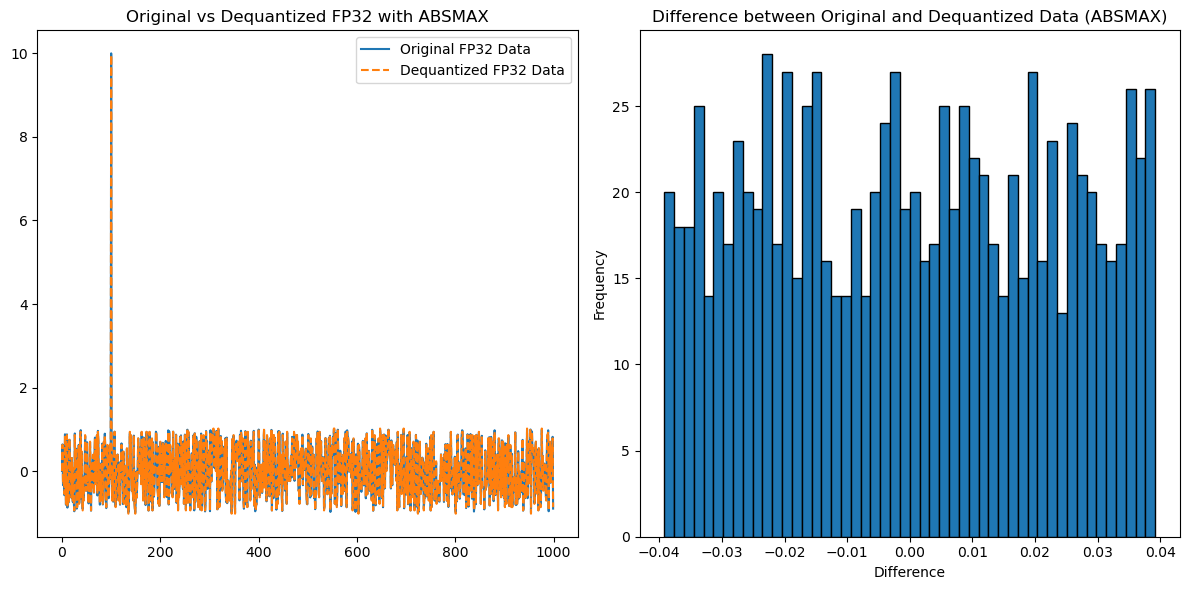

In [11]:
import numpy as np
import matplotlib.pyplot as plt

# 1. 원본 FP32 데이터를 생성 (예: -1.0에서 1.0 사이의 데이터에 outlier 추가)
fp32_data = np.random.uniform(-1.0, 1.0, 1000)
fp32_data[100] = 10.0  # 큰 값(Outlier) 추가

# 2. ABSMAX 양자화 함수
def absmax_quantize(fp32_data, int8_min, int8_max):
    absmax = np.max(np.abs(fp32_data))  # 절대 최대값 계산
    scale = (int8_max - int8_min) / (2 * absmax)  # 스케일 계산
    int8_data = fp32_data * scale
    return np.clip(np.round(int8_data), int8_min, int8_max).astype(np.int8), absmax

# 3. INT8 데이터를 다시 FP32로 복원하는 함수
def absmax_dequantize(int8_data, absmax, int8_min, int8_max):
    scale = (2 * absmax) / (int8_max - int8_min)  # 스케일 계산
    fp32_data = int8_data * scale
    return fp32_data

# 4. 양자화 및 역양자화 수행
int8_min, int8_max = -128, 127  # INT8 범위
int8_data, absmax_value = absmax_quantize(fp32_data, int8_min, int8_max)
dequantized_fp32_data = absmax_dequantize(int8_data, absmax_value, int8_min, int8_max)

# 5. 결과 비교 (원본 FP32와 복원된 FP32 비교)
plt.figure(figsize=(12, 6))

# 원본과 복원된 데이터를 비교하는 그래프
plt.subplot(1, 2, 1)
plt.plot(fp32_data, label="Original FP32 Data")
plt.plot(dequantized_fp32_data, label="Dequantized FP32 Data", linestyle="dashed")
plt.title("Original vs Dequantized FP32 with ABSMAX")
plt.legend()

# 차이를 확인하는 그래프
plt.subplot(1, 2, 2)
plt.hist(fp32_data - dequantized_fp32_data, bins=50, edgecolor='k')
plt.title("Difference between Original and Dequantized Data (ABSMAX)")
plt.xlabel("Difference")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()


#### Quantile 양자화
- 데이터 분포가 비대칭 적이거나 한쪽에 몰려 있을 때, 선형 양자화 보다 정밀도가 좋다(비선형 데이터 처리에 유리하다.)
- 데이터를 정렬하고 구간을 나누는 과정에서 추가적인 계산 비용이 발생한다.
- 이상치가 있을 경우 구간 분포를 맞추기 어려울 수 있으며 정밀도 손실이 발생한다.

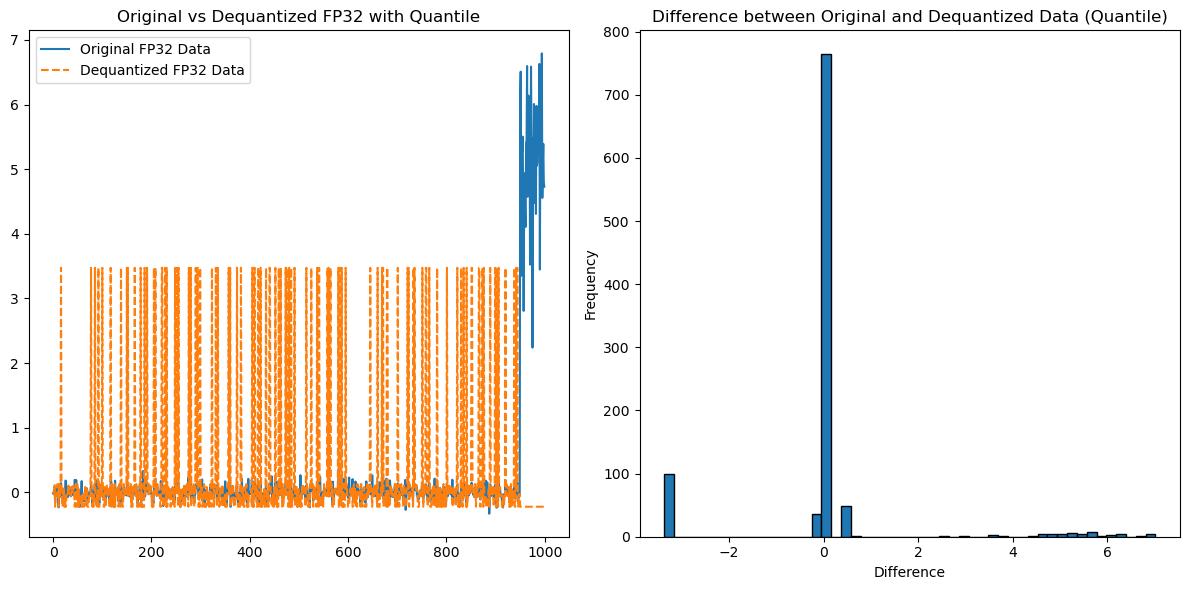

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import KBinsDiscretizer

# 1. 원본 FP32 데이터를 생성 (비선형 분포, outlier 추가)
fp32_data = np.concatenate([np.random.normal(0, 0.1, 950), np.random.normal(5, 1, 50)])

# 2. Quantile 방식 양자화 함수
def quantile_quantize(fp32_data, n_bins, int_min, int_max):
    # KBinsDiscretizer: 데이터 분포에 따라 구간을 나누는 기능
    discretizer = KBinsDiscretizer(n_bins=n_bins, encode='ordinal', strategy='quantile')
    fp32_data = fp32_data.reshape(-1, 1)  # 양자화에 맞게 차원 변경
    binned_data = discretizer.fit_transform(fp32_data).flatten()

    # INT 범위로 스케일 조정
    scale = (int_max - int_min) / (n_bins - 1)
    int_data = binned_data * scale + int_min
    return np.clip(np.round(int_data), int_min, int_max).astype(np.int8), discretizer

# 3. INT 데이터를 다시 FP32로 복원하는 함수
def quantile_dequantize(int_data, discretizer, int_min, int_max):
    n_bins = discretizer.n_bins_[0]
    scale = (int_max - int_min) / (n_bins - 1)
    
    # 양자화된 INT 값을 구간 중간값으로 복원
    binned_data = (int_data - int_min) / scale
    bin_midpoints = discretizer.bin_edges_[0][1:] - (discretizer.bin_edges_[0][1:] - discretizer.bin_edges_[0][:-1]) / 2
    fp32_data = np.array([bin_midpoints[int(val)] if val < len(bin_midpoints) else bin_midpoints[-1] for val in binned_data])
    return fp32_data

# 4. 양자화 및 역양자화 수행
int_min, int_max = -128, 127  # INT8 범위
n_bins = 10  # 양자화 구간 개수

int_data, discretizer = quantile_quantize(fp32_data, n_bins, int_min, int_max)
dequantized_fp32_data = quantile_dequantize(int_data, discretizer, int_min, int_max)

# 5. 결과 비교 (원본 FP32와 복원된 FP32 비교)
plt.figure(figsize=(12, 6))

# 원본과 복원된 데이터를 비교하는 그래프
plt.subplot(1, 2, 1)
plt.plot(fp32_data, label="Original FP32 Data")
plt.plot(dequantized_fp32_data, label="Dequantized FP32 Data", linestyle="dashed")
plt.title("Original vs Dequantized FP32 with Quantile")
plt.legend()

# 차이를 확인하는 그래프
plt.subplot(1, 2, 2)
plt.hist(fp32_data - dequantized_fp32_data, bins=50, edgecolor='k')
plt.title("Difference between Original and Dequantized Data (Quantile)")
plt.xlabel("Difference")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()


### GPU 메모리 분해하기 
- GPU 메모리에는 **모델, Gradient,Optimizer 상태, 순전파 상태**가 저장된다.

In [13]:
#메모리 사용량 측정 함수 구현
import torch

def print_gpu_utilization():
    if torch.cuda.is_available():
        used_memory = torch.cuda.memory_allocated() / 1024**3
        print(f"GPU 메모리 사용량: {used_memory:.3f} GB")


from transformers import AutoModelForCausalLM, AutoTokenizer

def load_model_and_tokenizer(model_id, peft=None):
    tokenizer = AutoTokenizer.from_pretrained(model_id)
    if peft is None:
        model = AutoModelForCausalLM.from_pretrained(model_id, torch_dtype="auto", device_map={"":0})

    print_gpu_utilization()
    return model, tokenizer

model_id = "EleutherAI/polyglot-ko-1.3b"
model, tokenizer = load_model_and_tokenizer(model_id) # GPU 메모리 사용량: 2.599 GB
print("모델 파라미터 데이터 타입: ", model.dtype) # torch.float16

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

GPU 메모리 사용량: 2.575 GB
모델 파라미터 데이터 타입:  torch.float16


- param.grad.nelement : 모델에 저장된 그레이디언트 값의 수
- param.grad.element_size : 값의 데이터 크기
- v.nelement : 옵티마이저에 저장된 값의 수
- v.element_size : 데이터 크기

In [14]:
# 그레이디언트와 옵티마이저 상태의 메모리 사용량 계산 함수
from transformers import AdamW
from torch.utils.data import DataLoader

def estimate_memory_of_gradients(model):
    total_memory = 0
    for param in model.parameters():
        if param.grad is not None:
            total_memory += param.grad.nelement() * param.grad.element_size()
    return total_memory

def estimate_memory_of_optimizer(optimizer):
    total_memory = 0
    for state in optimizer.state.values():
        for k, v in state.items():
            if torch.is_tensor(v):
                total_memory += v.nelement() * v.element_size()
    return total_memory

### 학습과정 중 메모리 사용량 확인

In [15]:

def train_model(model, dataset, training_args):
    if training_args.gradient_checkpointing:
        model.gradient_checkpointing_enable()

    train_dataloader = DataLoader(dataset, batch_size=training_args.per_device_train_batch_size)
    optimizer = AdamW(model.parameters())
    model.train()
    gpu_utilization_printed = False
    for step, batch in enumerate(train_dataloader, start=1):
        batch = {k: v.to(model.device) for k, v in batch.items()}

        outputs = model(**batch)
        loss = outputs.loss
        loss = loss / training_args.gradient_accumulation_steps
        loss.backward()

        if step % training_args.gradient_accumulation_steps == 0:
            optimizer.step()
            gradients_memory = estimate_memory_of_gradients(model)
            optimizer_memory = estimate_memory_of_optimizer(optimizer)
            if not gpu_utilization_printed:
                print_gpu_utilization()
                gpu_utilization_printed = True
            optimizer.zero_grad()

    print(f"옵티마이저 상태의 메모리 사용량: {optimizer_memory / (1024 ** 3):.3f} GB")
    print(f"그레디언트 메모리 사용량: {gradients_memory / (1024 ** 3):.3f} GB")

In [16]:
# 모델 학습을 위한 데이터 생성
import numpy as np
from datasets import Dataset

def make_dummy_dataset():
  seq_len, dataset_size = 256, 64
  dummy_data = {
      "input_ids": np.random.randint(100, 30000, (dataset_size, seq_len)),
      "labels": np.random.randint(100, 30000, (dataset_size, seq_len)),
  }
  dataset = Dataset.from_dict(dummy_data)
  dataset.set_format("pt")
  return dataset

##### clean 함수 만들기
전역 변수 중 gpu 메모리에 올라가는 모델의 변수(model)와 데이터셋 변수(dataset)를 삭제하고 gc.collect 함수를 통해 사용하지 않는 메모리를 회수하는 가비지 컬렉션(garbarge collection)을 수동으로 수행한다. torch.cuda.empty_cache() 함수는 더이상 사용하지 않는 GPU 메모리를 반환한다.

In [17]:
# 사용하지 않는 GPU 메모리 반환하기
import gc

def clean():
    if 'model' in globals():
        del globals()['model']
    if 'dataset' in globals():
        del globals()['dataset']
    gc.collect()
    torch.cuda.empty_cache()

#### 종합 함수 (배치크기,그레이디언트 누적,그레이디언트 체크포인팅, peft 설정 등에 따라 gpu 사용량 확인)
1. load_model_and_tokenizer 함수와 make_dummy_dataset 함수로 모델,토크나이저,데이터셋 로드
2. train_model 함수로 학습 진행하면서 GPU 메모리 확인
3. 실험이 끝난 모델과 데이터셋을 삭제하고 사용하지 않는 메모리 반환

In [18]:
from transformers import TrainingArguments, Trainer

def gpu_memory_experiment(batch_size,
                          gradient_accumulation_steps=1,
                          gradient_checkpointing=False,
                          model_id="EleutherAI/polyglot-ko-1.3b",
                          peft=None):

    print(f"배치 사이즈: {batch_size}")
    model, tokenizer = load_model_and_tokenizer(model_id, peft=peft)
    if gradient_checkpointing == True or peft == 'qlora':
        model.config.use_cache = False

    dataset = make_dummy_dataset()

    training_args = TrainingArguments(
        per_device_train_batch_size=batch_size,
        gradient_accumulation_steps=gradient_accumulation_steps,
        gradient_checkpointing=gradient_checkpointing,
        output_dir="./result",
        num_train_epochs=1
      )

    try:
        train_model(model, dataset, training_args)
    except RuntimeError as e:
        if "CUDA out of memory" in str(e):
            print(e)
        else:
            raise e
    finally:
        del model, dataset
        gc.collect()
        torch.cuda.empty_cache()
        print_gpu_utilization()

#### 배치 크기 변경하면서 메모리 사용량 측정하기 결과
배치 크기를 변경하면서 측정해도 모델,그레이디언트,옵티마이저 상태를 저장하는데 필요한 GPU 메모리는 동일하다. 총 메모리가 증가하는 것은 **<span style= 'color : blue'> 순전파 상태의 계산에 필요한 메모리가 증가한다는 사실**


In [19]:
clean()
print_gpu_utilization()
for batch_size in [4,8]:
    gpu_memory_experiment(batch_size)
    torch.cuda.empty_cache()
    

GPU 메모리 사용량: 0.000 GB
배치 사이즈: 4


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

GPU 메모리 사용량: 2.575 GB
GPU 메모리 사용량: 10.469 GB
옵티마이저 상태의 메모리 사용량: 4.961 GB
그레디언트 메모리 사용량: 2.481 GB
GPU 메모리 사용량: 0.016 GB
배치 사이즈: 8


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

GPU 메모리 사용량: 2.591 GB
GPU 메모리 사용량: 10.902 GB
옵티마이저 상태의 메모리 사용량: 4.961 GB
그레디언트 메모리 사용량: 2.481 GB
GPU 메모리 사용량: 0.016 GB


## 1개의 GPU 효율적으로 사용하기
- 그레이디언트 누적 : 모델 학습시 배치마다 모델을 업데이트 하지 않고 **여러 배치의 학습 데이터를 연산 한 후 모델을 업데이트** 해 더 큰 배치 크기 사용하는 것과 같은 효과를 내는 방법
- 그레이디언트 체크포인팅 : 순전파의 계산 결과를 모두 저장하지 않고 **일부만 저장해 학습 중 GPU 메모리의 사용량을 줄이는 방법**

### 그레이디언트 누적
- 제한된 메모리 안에서 배치 크기를 키우는 것과 동일한 효과
- 학습인자(training_args)에서 그레이디언트 누적 횟수(gradient_accumulation_steps)를 4로 두면 손실을 4로 나눠 역전파를 수행하고 4번의 스텝마다 모델을 업데이트해 배치 크기가 4로 커진것과 동일한 효과
- 예를 들어 배치크기를 16으로 설정했을 때 OOM 에러가 발생했다면, 배치크기를 4, 누적을 4로 설정하면 배치 크기 16의 효과를 얻을 수 있다. 하지만 추가적인 순전파와 역전파 연산을 수행하기 때문에 학습시간이 증가한다.

In [20]:
##누적을 사용하지 않았을 때
clean()
gpu_memory_experiment(batch_size=8)

torch.cuda.empty_cache()
## 누적을 사용했을 때
clean()
gpu_memory_experiment(batch_size=4,gradient_accumulation_steps=4)
torch.cuda.empty_cache()

배치 사이즈: 8


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

GPU 메모리 사용량: 2.591 GB
GPU 메모리 사용량: 10.902 GB
옵티마이저 상태의 메모리 사용량: 4.961 GB
그레디언트 메모리 사용량: 2.481 GB
GPU 메모리 사용량: 0.016 GB
배치 사이즈: 4


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

GPU 메모리 사용량: 2.591 GB
GPU 메모리 사용량: 10.469 GB
옵티마이저 상태의 메모리 사용량: 4.961 GB
그레디언트 메모리 사용량: 2.481 GB
GPU 메모리 사용량: 0.016 GB


### 그레이디언트 체크포인팅
- 역전파 연산을 위해 순전파의 결과를 저장하고 있는데, 이러면 GPU 메모리를 많이 차지하게 된다.  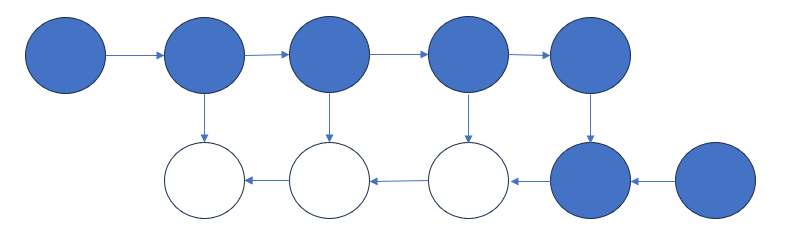
    - 메모리 절약을 위해 역전파를 진행하면서 사용이 끝난 데이터는 삭제한다.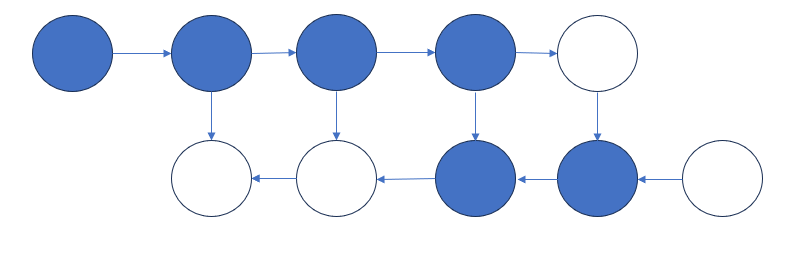

    - 메모리 효율성을 높이기 위해 역전파 계산 시 필요한 최소 데이터만 저장하고 나머지는 필요할 때 다시 계산하는 방법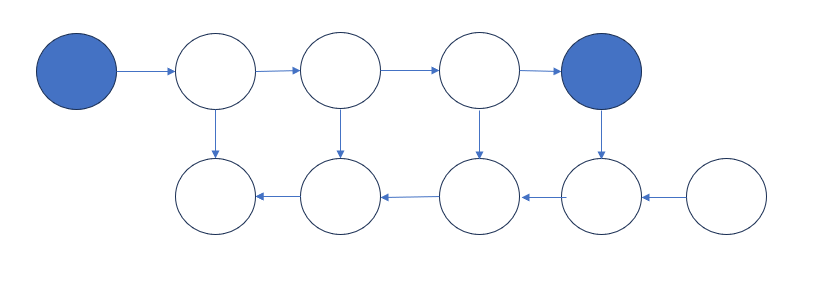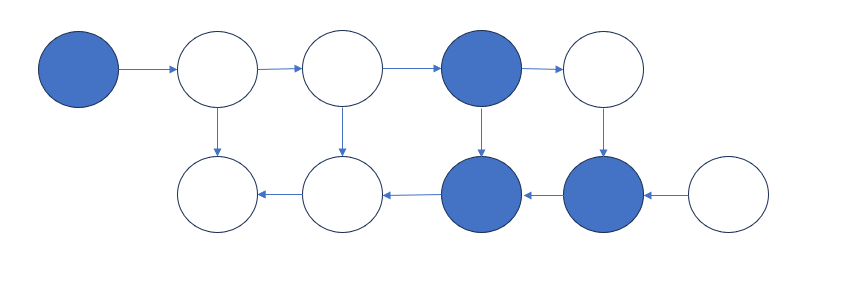
- 이 두가지 방식을 절충하기 위한 방법이 **그레이디언트 체크포인팅** 이다. 중간중간에 값들을 저장(체크)해서 메모리 사용을 줄이고 체크포인트 부터 다시 계산해 순전파 계산량도 줄인다.

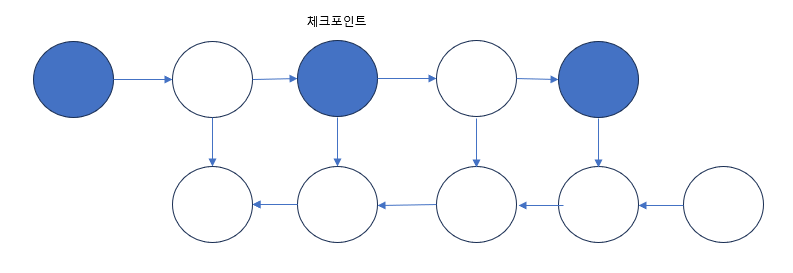
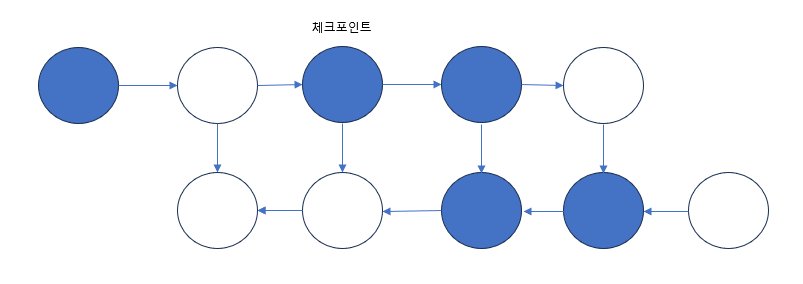

## 분산학습(2개 이상의 GPU)과 ZeRO
### 분산학습
- 데이터 병렬화 : **모델이 작아서** 여러 GPU에 각각 올리고 데이터를 병렬로 처리해 학습속도 향상
- 모델 병렬화   : GPU에 올리기 어려운 큰 모델의 경우 모델을 여러개 GPU에 나눠서 올리는 방식
    - layer별로 나눠 GPU에 올리는 **파이프라인 병렬화** (아래 그림에서 머신 1,2와 머신 3,4로 구분하면)
    - 한 층의 모델도 나눠서 GPU에 올리는 **텐서 병렬화** (아래 그림에서 머신 1,3과 머신 2,4로 구분하면)

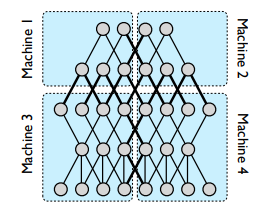


### 데이터 병렬화에서 중복 저장 줄이기(ZeRO)
- 데이터 병렬화는 모델이 여러 GPU에 동일하게 올라가 중복으로 메모리를 차지 하기 때문에 비효율적이다.
- ZeRO는 하나의 모델을 하나의 GPU에 올리지 않고 마치 모델 병렬화 처럼 모델을 나눠 여러 GPU에 올리고 각 GPU에서는 **자신의 모델 부분의 연산만 수행하고 그상태를 저장**해 메모리를 효율적으로 사용한다는 컨셉이다.
- Accelerate의 딥스피드 사용 가이드(https://huggingface.co/docs/accelerate/usage_guides/deepspeed) 에서 더 확인 가능

## 효율적인 학습방법(PEFT): LoRA
LLM과 같은 모델의 크기가 커지면서 하나의 GPU를 사용해 full fine-tuning 수행이 어려워졌다. 대부분의 개인 혹은 조직은 여러 GPU를 사용해 모델학습이 어렵기 때문에 **일부 파라미터만 학습하는 PEFT(Parameter Efficient Fine-Tuning)** 연구가 활발히 이루어진다. 
### 모델 파라미터의 일부만 재구성해 학습하는 LoRA
- 모델 파라미터를 재구성해 더 적은 파라미터를 학습함으로 GPU 사용량을 줄인다.
<div style="text-align: center;">
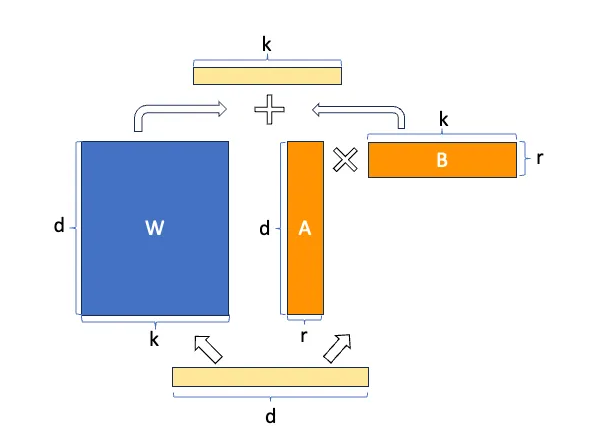
</div>
$W$를 학습 시키는 것이 아닌 $W$는 고정하고 $(d,r),(r,k)$차원으로 나누어$(d,k)$행렬로 만드는 것이다. 예를들어$d=100,k=100$,$r=4$ 라면 행렬 $W$는 $100\times100= 10,000$개의 파라미터를 조정해야하는데 LoRA의 경우 행렬 $A=100*4=400$ 행렬 $B=4*100=400$로 800개의 파라미터만 학습 하면서 $W$를 변경하는 것과 같은 효과를 얻을 수 있다.

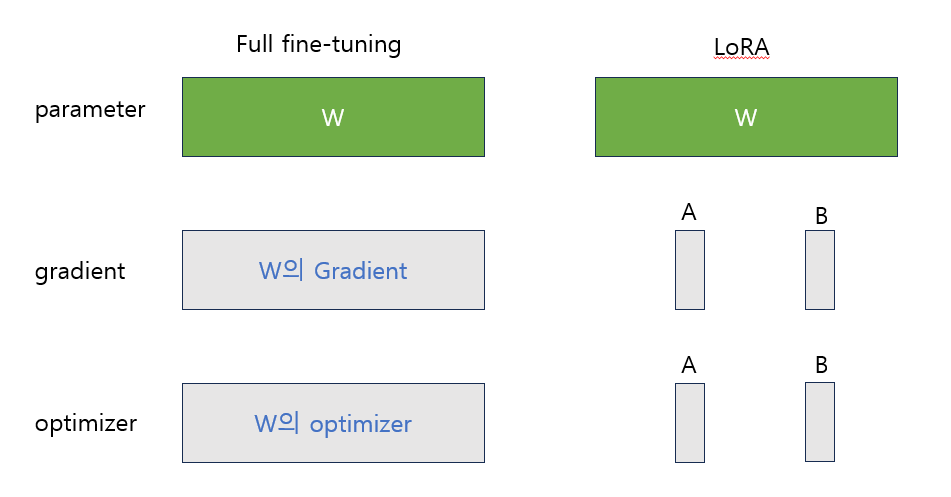
<br>$행렬 A와 B가 추가되었는데 GPU 사용량이 줄어드냐면, A,B는 파라미터 W에 비해 훨씬 작기 때문에 파라미터의 수가 줄어들면 **모델 업데이트에 사용되는 옵티마이저 상태의 데이터가 줄어듦**, LoRA를 통해 **메모리 사용량이 줄어드는 부분은 그레이디언트와 옵티마이저 상태 저장 필요 메모리가 줄어들기 때문**

1. 그래서 $r$을 설정하는것이 중요하다. $r$이 너무 작아질 경우 용량이 작아져 충분한 학습을 못할 수 있다.
2. 추가한 파라미터를 기존 파라미터에 얼마나 많이 반영할지 결정하는 $\alpha$가 있는데 행렬 A,B를 곱한 부분을 파라미터 W와 동일하게 더해줄수 있지만, 행렬 A,B를 더 중요하게 고려할 수도있다. LoRA에서는 **행렬 A,B를 $\alpha /r$만큼의 비중으로 W에 더해준다** 즉,<span style='color:blue'>**알파가 커질수록 새 학습한 파라미터의 중요성을 크게 고려한다고 볼 수 있다**</span>
3. 어떤 파라미터를 재구성할지 결정해야 한다.일반적으로 셀프 어텐션의 q,k,v 가중치와 feedforward의 가중치와 같이 선형 연산의 가중치를 재구성한다. 이중에서 특정 가중치만 적용할 수도 있다.

### 코드로 LoRA 학습 사용하기

In [21]:
from transformers import AutoModelForCausalLM,AutoTokenizer
from peft import LoraConfig,get_peft_model

def load_model_and_tokenizer(model_id,peft=None):
    tokenizer = AutoTokenizer.from_pretrained(model_id)

    if peft is None:
        model = AutoModelForCausalLM.from_pretrained(model_id,torch_dtype = 'auto',device_map={"":0})
    elif peft == 'lora':
        model = AutoModelForCausalLM.from_pretrained(model_id,torch_dtype = 'auto',device_map={"":0})
        lora_config = LoraConfig(r=8,
                                lora_alpha=32,
                                target_modules=['query_key_value'],
                                lora_dropout=0.05,
                                bias='none',
                                task_type='CAUSAL_LM')
        #모델 재구성 후에 학습 파라미터를 재구성하는 get_peft_model 함수 호출
        model = get_peft_model(model,lora_config)
        #학습 파라미터 수와 비중을 확인
        model.print_trainable_parameters()
    print_gpu_utilization()
    return model, tokenizer
clean()
print_gpu_utilization()
gpu_memory_experiment(batch_size=16,peft='lora')
torch.cuda.empty_cache()

GPU 메모리 사용량: 0.016 GB
배치 사이즈: 16


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

trainable params: 1,572,864 || all params: 1,333,383,168 || trainable%: 0.11796039111242178
GPU 메모리 사용량: 2.594 GB
GPU 메모리 사용량: 4.334 GB
옵티마이저 상태의 메모리 사용량: 0.006 GB
그레디언트 메모리 사용량: 0.003 GB
GPU 메모리 사용량: 0.016 GB


## 효율적인 학습방법(PEFT): QLoRA
LoRA에 **양자화**를 추가해 메모리 효율성을 더 높인 방법,양자화는 기존 데이터를 더 적은 메모리를 사용하는 데이터 형식으로 변환하는 방법
QLoRA는 학습 도중 OOM에러가 발생하지 않도록 페이지 옵티마이저(paged optimizer)기능을 활용.
#### 4비트 양자화와 2차 양자화
- 양자화의 핵심은 기존 데이터를 최대한 유지하면서 더 적은 비트를 사용하는 데이터 형식으로 변환하는 것
- 기존 데이터의 순위대로 새로운 데이터 형식에 매핑하는 방법을 사용할 수 있다. 하지만 데이터의 순서를 사용하는 경우 데이터를 정렬해야 하고 어떤데이터가 몇번째 순위에 있었는지 저장해야하기 때문에 연산량이 많고 메모리 소모의 단점이 있다.
- 만약 데이터의 분포를 알고 있다면 메모리 사용없이 빠르게 순위를 정할 수 있다. 예를 들어 정규 분포를 따른다면 균등하게 분리하기 위해 경곗값을 정규분포를 따르게 분할 할 수 있다. 4비트만 사용해 16개의 수를 사용한다면 16등분 할 수 있는 경곗값을 찾고 입력 데이터가 경계값 기준으로 큰지 작은지에 따라 0~15까지 배정하면 된다.


In [22]:
from scipy.stats import norm

def quantile_normal(q):
    return norm.ppf(q)
print(quantile_normal(0.5))
print(quantile_normal(0.6))

0.0
0.2533471031357997


학습된 모델의 파라미터는 대부분 정규분포에 가깝다고 알려져 있다. LLaMa모델 확인 했을 때 92.5%의 파라미터가 정규분포를 따랐다. 따라서 입력이 정규분포라는 가정을 활용하면 성능을 거의 유지하면서 빠른 양자화가 가능해진다. **QLoRA논문 에서는 4비트 부동소수점 데이터 형식(NF4)를 제안했다.** 4비트 양자화에서 더 나아가 <span style='color:blue'>**2차 양자화**</span>도 수행한다. 


In [23]:
import torch
import torch.nn as nn
import torch.optim as optim

# 4비트 양자화 함수 (가중치 및 그래디언트에 사용)
def quantize_4bit(tensor):
    # 가중치를 4비트로 스케일링
    min_val = tensor.min()
    max_val = tensor.max()
    scale = (max_val - min_val) / 15  # 4비트 = 16단계 양자화
    tensor_q = ((tensor - min_val) / scale).round().clamp(0, 15)  # 양자화
    tensor_deq = tensor_q * scale + min_val  # 역양자화
    return tensor_deq

# 간단한 신경망 정의
class SimpleModel(nn.Module):
    def __init__(self):
        super(SimpleModel, self).__init__()
        self.fc1 = nn.Linear(784, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# 양자화된 그래디언트 계산 함수 (2차 양자화)
def quantize_gradients(model):
    for param in model.parameters():
        if param.grad is not None:
            param.grad.data = quantize_4bit(param.grad.data)  # 그래디언트를 4비트로 양자화

# 모델 생성 및 손실함수, 옵티마이저 정의
model = SimpleModel()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

# 가짜 데이터 및 레이블 생성 (MNIST 이미지 28x28 = 784 크기)
inputs = torch.randn(64, 784)  # 64개의 샘플 배치
labels = torch.randint(0, 10, (64,))  # 10개의 클래스

# 모델 학습 과정
for epoch in range(2):  # 2번의 에폭 동안 학습
    optimizer.zero_grad()  # 그래디언트 초기화
    
    # 순전파
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    
    # 역전파 및 그래디언트 계산
    loss.backward()

    # 2차 양자화: 그래디언트를 4비트로 양자화
    quantize_gradients(model)

    # 옵티마이저를 사용한 가중치 업데이트
    optimizer.step()

    # 4비트 양자화 적용 (가중치 양자화)
    for param in model.parameters():
        param.data = quantize_4bit(param.data)
    
    print(f"Epoch {epoch+1}, Loss: {loss.item()}")

# 양자화 후 가중치와 그래디언트 확인
print("Quantized weights (after training):", model.fc1.weight)


Epoch 1, Loss: 2.3255016803741455
Epoch 2, Loss: 2.3021411895751953
Quantized weights (after training): Parameter containing:
tensor([[ 0.0216, -0.0264,  0.0120,  ..., -0.0024,  0.0168,  0.0072],
        [-0.0216,  0.0216, -0.0360,  ...,  0.0312,  0.0312,  0.0120],
        [-0.0216, -0.0360,  0.0072,  ..., -0.0168,  0.0120,  0.0216],
        ...,
        [ 0.0312, -0.0216,  0.0216,  ..., -0.0216, -0.0216,  0.0024],
        [ 0.0120, -0.0312,  0.0024,  ..., -0.0168, -0.0072, -0.0072],
        [-0.0120, -0.0312,  0.0264,  ..., -0.0072, -0.0120,  0.0216]],
       requires_grad=True)


코드 설명
- 양자화 함수: quantize_4bit(tensor) 함수는 텐서를 4비트로 양자화하고 다시 역양자화하는 기능을 합니다. 이 함수는 가중치와 그래디언트 모두에 사용됩니다.
- 모델 정의: SimpleModel은 간단한 신경망 모델입니다. 첫 번째 층은 입력 크기가 784이고 출력이 128인 Fully Connected (FC) 레이어이고, 두 번째 층은 128에서 10으로 이어집니다.
- 2차 양자화: quantize_gradients(model) 함수는 역전파 후 모든 가중치의 그래디언트를 4비트로 양자화합니다.
- 학습 과정: 두 번의 에폭 동안 모델을 학습하면서, 매번 순전파 후 역전파를 통해 손실을 계산하고 그래디언트를 얻습니다.
2차 양자화는 그래디언트 계산 후 바로 적용되어 4비트로 양자화된 그래디언트가 가중치 업데이트에 사용됩니다.
가중치 양자화는 매번 학습 후 가중치를 4비트로 양자화합니다.

#### 페이지 옵티마이저(paged optimizer)

- QLoRA 논문에서는 gradient checkpointing 과정에서 발생할 수 있는 OOM 에러를 방지 하기 위해 paged optimizer를 활용한다.
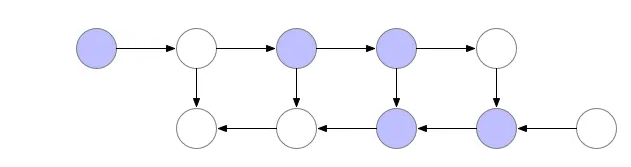

- 위 과정에서 역전파 수행 시 5개 노드 데이터를 저장해야 하는데 일시적으로 메모리 사용량이 커지기 때문에 이를 대응하기 위해 paged optimizer 사용
- **엔비디아의 통합 메모리를 통해 GPU가 CPU(RAM)을 공유하는 것을 말함** 엔비디아의 통합 메모리는 가상 메모리 시스템과 유사한 개념을 GPU 메모리 관리에 적용한 기술이다. 가상 메모리는 RAM과 DISK를 사용해 더 많은 메모리를 가진 것 처럼 작동하게 해준다.
- <span style='color:blue'>가상메모리에서 OS는 램이 가득차면 일부 데이터를 디스크로 옮기고 필요할 때 다시 램으로 데이터를 불러오는데 이를 **페이징**이라고 한다.</span>
- 엔비디아의 통합 메모리도 GPU가 처리해야 할 데이터가 많을 때 일부 데이터를 CPU의 메모리에 보관한다. CPU의 데이터가 필요해지면 그때 해당 데이터를 CPU에서 GPU로 옮겨 처리한다.

#### 4비트 양자화 모델 불러오기

In [24]:
from transformers import BitsAndBytesConfig ,AutoModelForCausalLM
nf4_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=True,
    bnb_4bit_compute_dtype=torch.bfloat16
)
model_nf4 = AutoModelForCausalLM.from_pretrained(model_id, quantization_config=nf4_config)

`low_cpu_mem_usage` was None, now set to True since model is quantized.


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

#### QLoRA 모델 불러오기 추가

In [25]:
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training

def load_model_and_tokenizer(model_id, peft=None):
    tokenizer = AutoTokenizer.from_pretrained(model_id)

    if peft is None:
        model = AutoModelForCausalLM.from_pretrained(model_id, torch_dtype="auto", device_map={"":0})

    elif peft == 'lora':
        model = AutoModelForCausalLM.from_pretrained(model_id, torch_dtype="auto", device_map={"":0})
        lora_config = LoraConfig(
                    r=8,
                    lora_alpha=32,
                    target_modules=["query_key_value"],
                    lora_dropout=0.05,
                    bias="none",
                    task_type="CAUSAL_LM"
                )

        model = get_peft_model(model, lora_config)
        model.print_trainable_parameters()
    elif peft == 'qlora':
        lora_config = LoraConfig(
                    r=8,
                    lora_alpha=32,
                    target_modules=["query_key_value"],
                    lora_dropout=0.05,
                    bias="none",
                    task_type="CAUSAL_LM"
                )
        bnb_config = BitsAndBytesConfig(
                  load_in_4bit=True,
                  bnb_4bit_use_double_quant=True,
                  bnb_4bit_quant_type="nf4",
                  bnb_4bit_compute_dtype=torch.float16
              )
        model = AutoModelForCausalLM.from_pretrained(model_id, quantization_config=bnb_config, device_map={"":0})
        model.gradient_checkpointing_enable()
        model = prepare_model_for_kbit_training(model)
        model = get_peft_model(model, lora_config)
        model.print_trainable_parameters()

    print_gpu_utilization()
    return model, tokenizer

#### QLoRA 적용시 GPU 메모리 사용 확인

In [26]:
clean()
print_gpu_utilization()

gpu_memory_experiment(batch_size=16, peft='qlora')

torch.cuda.empty_cache()

GPU 메모리 사용량: 0.922 GB
배치 사이즈: 16


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

trainable params: 1,572,864 || all params: 1,333,383,168 || trainable%: 0.11796039111242178
GPU 메모리 사용량: 2.065 GB
GPU 메모리 사용량: 2.604 GB
옵티마이저 상태의 메모리 사용량: 0.012 GB
그레디언트 메모리 사용량: 0.006 GB
GPU 메모리 사용량: 0.922 GB


## 정리
- GPU에는 크게 **모델 파라미터, 그레이디언트,옵티마이저 상태, 순전파 상태**를 저장한다.
- 모델 파라미터 저장을 위해 일반적으로 **16비트의 소수 데이터 형식인 fp16과 bf16을 주로 사용**하지만 더 큰모델을 다루기 위해 **8,4비트로 양자화** 하는 방식도 사용한다.
- 단일 GPU에서 모델을 효율적으로 학습할 수 있는 **그레이디언트 누적**(제한된 GPU로 큰 배치 크기로 학습하는 것과 같은 효과), **그레이디언트 체크포인트**(순전파 상태를 모두 저장하지 않음)
- 2개 이상 GPU의 분산학습 방식에는 **모델병렬화**(딥러닝 모델을 층별로 별도의 GPU에 올리는 파이프라인 병렬화,하나의 층도 서로다른 GPU에 올리는 텐서 병렬화),**데이터 병렬화**는 동일한 모델을 여러GPU에 올려 GPU 메모리를 비효율적으로 사용하기 때문에 중복을 줄여 사용하는 ZeRO
- 모델의 finetuning을 해결하기 위해 일부만 학습하는 **PEFT**,그 중에서 파라미터를 재구성해 적은 학습파라미터를 추가하는 **LoRA**와 LoRA에 4비트 양자화를 추가한** QLoRA**